# Return Period for La ReUnion Best Track Data

This notebook reviews the return period using La ReUnion Best Track data

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from datetime import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from shapely.geometry import Point
from src.datasources import codab, rsmc, ecmwf
from src.utils import categorize_cyclone, category_order

In [3]:
save_dir = rsmc.DATA_DIR / "public" / "exploration" / "moz" / "ecmwf_hindcast"

<Axes: >

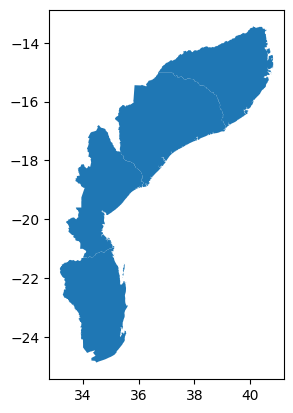

In [4]:
adm = codab.load_codab(aoi_only=True)
adm.plot()

In [5]:
# loading all actual cyclone tracks
cyclone_tracks = pd.read_csv(
    rsmc.DATA_DIR
    / "private"
    / "raw"
    / "moz"
    / "rsmc"
    / "data_cyclone_SWIO_19851986_to_20222023.csv"
)

In [6]:
cyclone_tracks["Lat"] = cyclone_tracks["Lat"].apply(
    lambda x: -x if x > 0 else x
)

In [7]:
cyclone_tracks["geometry"] = cyclone_tracks.apply(
    lambda row: Point(row["Lon"], row["Lat"]), axis=1
)
cyclone_tracks_gdf = gpd.GeoDataFrame(
    cyclone_tracks, geometry="geometry", crs="EPSG:4326"
)

In [8]:
cyclone_tracks_sel = gpd.sjoin(
    cyclone_tracks_gdf, adm, how="inner", predicate="intersects"
)

<Axes: >

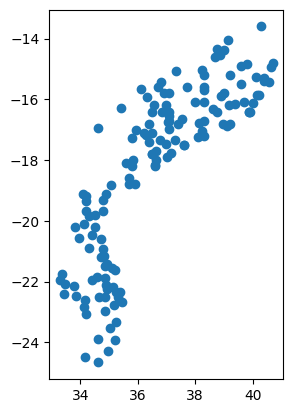

In [9]:
cyclone_tracks_sel.plot()

In [10]:
cyclone_tracks_sel["Name"].unique()

array(['FILAO', 'DESSILIA', 'NADIA', 'BONITA', 'LISETTE', 'A19798',
       'ASTRIDE', 'ELINE', 'GLORIA', 'HUDAH', 'DELFINA', 'JAPHET',
       '720052006', 'FAVIO', 'JAYA', 'JOKWE', 'IZILDA', 'DANDO', 'IRINA',
       'HARUNA', 'DELIWE', '920132014', 'GUITO', 'HELLEN', 'CHEDZA',
       'DINEO', '420172018', 'DESMOND', 'IDAI', 'KENNETH', 'CHALANE',
       'ELOISE', 'GUAMBE', 'ANA', 'DUMAKO', 'GOMBE', 'JASMINE', 'FREDDY'],
      dtype=object)

In [11]:
def calculate_storm_return_period_la_reunion(
    df, wind_speed_kmh, start_year, num_storms_year
):
    from datetime import datetime
    import math

    # Conversion factor from kilometers per hour to knots
    kmh_to_knots = 1 / 1.852

    # Convert the given speed from km/h to knots
    speed_knots = wind_speed_kmh * kmh_to_knots

    # Ensure UTC is formatted as a two-digit hour
    df["UTC"] = df["UTC"].apply(lambda x: f"{int(x):02}")
    # Create a datetime column from separate date and time columns
    df["ISO_TIME"] = pd.to_datetime(
        df[["Year", "Month", "Day", "UTC"]].astype(str).agg(" ".join, axis=1)
    )

    # Extract the year from the 'ISO_TIME' column
    df["year"] = df["ISO_TIME"].dt.year

    # Filter the DataFrame for records from the start year and with wind speed above the threshold
    df_filtered = df[
        (df["year"] >= start_year) & (df["Max wind (kt)"] >= speed_knots)
    ]

    # Count unique storms
    unique_storms = df_filtered["Name"].nunique()

    # Calculate the total number of years in the filtered DataFrame
    yr_len = 2023 - start_year + 1

    # Calculate the combined return period
    combined_return_period = yr_len / unique_storms

    print(
        f"The combined return period of storms over {wind_speed_kmh} km/h is 1-in-{round(combined_return_period, 1)} years."
    )

    # Calculate return periods for each administrative region
    admin_return_periods = {}

    grouped = df_filtered.groupby("ADM1_PT")
    for admin, group in grouped:
        admin_unique_storms = group["Name"].nunique()
        admin_return_period = yr_len / admin_unique_storms
        admin_return_periods[admin] = admin_return_period

        print(
            f"The return period of storms over {wind_speed_kmh} km/h in {admin} is 1-in-{round(admin_return_period, 1)} years."
        )

    # Calculate probabilities using the Poisson distribution
    ave_num = unique_storms / yr_len
    expected_probability = (
        math.exp(-ave_num)
        * (ave_num**num_storms_year)
        / math.factorial(num_storms_year)
    )
    print(
        f"The probability of exactly {num_storms_year} storms making landfall in an average year is {round(expected_probability * 100, 1)}%."
    )
    print(
        f"The return period of exactly {num_storms_year} storms making landfall in an average year is 1-in-{round(1 / expected_probability, 1)} years."
    )

In [12]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel,
    wind_speed_kmh=89,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 89 km/h is 1-in-3.4 years.
The return period of storms over 89 km/h in Inhambane is 1-in-11.0 years.
The return period of storms over 89 km/h in Nampula is 1-in-22.0 years.
The return period of storms over 89 km/h in Sofala is 1-in-8.8 years.
The return period of storms over 89 km/h in Zambezia is 1-in-11.0 years.
The probability of exactly 1 storms making landfall in an average year is 22.0%.
The return period of exactly 1 storms making landfall in an average year is 1-in-4.5 years.


In [13]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel,
    wind_speed_kmh=118,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 118 km/h is 1-in-4.0 years.
The return period of storms over 118 km/h in Inhambane is 1-in-14.7 years.
The return period of storms over 118 km/h in Nampula is 1-in-22.0 years.
The return period of storms over 118 km/h in Sofala is 1-in-11.0 years.
The return period of storms over 118 km/h in Zambezia is 1-in-14.7 years.
The probability of exactly 1 storms making landfall in an average year is 19.5%.
The return period of exactly 1 storms making landfall in an average year is 1-in-5.1 years.
